# BCycle Austin stations

This notebook looks at the stations that make up the Austin BCycle network. For each station we have the following information:

* `station_id`: A unique identifier for each of the station. Used to connect the `bikes.csv` time-varying table to the static `stations` table.
* `name`: The name of the station. This is the nearest cross street to the station, or if the station is located at a building, the name of that building.
* `address`: The address of the station. Note that if a company sponsors the station, it will include their name, for example 'Presented by Whole Foods Market'. For this reason, its best not to geocode this field to a lat/lon pair, and use those values from the respective fields.
* `lat`: The latitude of the station.
* `lon`: The longitude of the station.
* `datetime`: The date and time that the station was first reported when fetching the BCycle Station webpage.

## Imports and data loading

Before getting started, let's import some useful libraries (including the bcycle_lib created for these notebooks), and load the stations CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the stations table, and show the first 10 entries
STATIONS = 5
stations_df = load_stations()
num_stations = stations_df.shape[0]
print('Found {} stations, showing first {}'.format(num_stations, STATIONS))
stations_df.head(STATIONS)


Found 50 stations, showing first 5


,station_id,name,address,lat,lon,datetime
0,1,2nd & Congress,"151 E. 2nd St, Austin, TX 78701",30.264080,-97.743553,2016-04-01
1,2,4th & Congress,"120 W. 4th St., Austin, TX 78701",30.266340,-97.743782,2016-04-01
2,3,8th & Congress,"111 E. 8th St., Austin, TX 78701",30.269800,-97.741859,2016-04-01
3,4,Capitol Station / Congress & 11th,"1090 Congress Ave., Austin, TX 78701",30.272600,-97.741272,2016-04-01
4,5,City Hall / Lavaca & 2nd,"Presented by Graves Dougherty Hearon & Moody, ...",30.264759,-97.746780,2016-04-01


## Plot the stations on a map of Austin

Let's plot all the stations on an Open Street Map of Austin, to see where they're concentrated. We can use the latitude and longitude of the stations to center the map. To find out the name of the station, click on the marker.

In [3]:
# Calculate where the map should be centred based on station locations
min_lat = stations_df['lat'].min()
max_lat = stations_df['lat'].max()
min_lon = stations_df['lon'].min()
max_lon = stations_df['lon'].max()
center_lat = min_lat + (max_lat - min_lat) / 2.0
center_lon = min_lon + (max_lon - min_lon) / 2.0

# Plot map using the B&W Stamen Toner tiles centred on BCycle stations
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Add markers to the map for each station. Click on them to see their name
for station in stations_df.iterrows():
    stat=station[1]
    folium.Marker([stat['lat'], stat['lon']],
              popup=stat['name'],
              icon=folium.Icon(icon='info-sign')
             ).add_to(map)

map.save('stations.html')
map

There are a total of 50 stations, which can be roughly clustered into 4 different groups:

* Stations around the University, North of 11th Street. UT Austin buildings and student housing is based in this area, so bikes could be used to get around without the expense and hassle of having a car.

* The downtown stations south of 11th Street, and north of the river. Austin's downtown is a mixture of residential and business buildings, so these stations could used for commute start and end points. There are also many bars on 6th Street, especially towards I-35.

* The stations east of I-35, including those on East 5th and 11th streets. This area is almost an overspill from the downtown area, with a similar amount of nightlife. There are fewer businesses in this area compared to downtown. This area also has a light rail, which connects downtown Austin with North Austin, and up to Cedar Park and Leander.

* Stations south of Lady Bird Lake. South Congress is good for nightlife, making it a popular destination on weekends and evenings. It also has limited parking, which you don't need to worry about when using a bike. There is also a bike and hike trail that runs along Lady Bird Lake on the North and South banks, which a lot of people enjoy on a bike.

## Station bike capacity histogram

Now we've visualized where each station in the system is, let's show how many combined bikes and docks each of the stations has (their capacity). To do this we need to load in the bikes dataframe, and calculate the maximum of `bikes + docks` for each of the stations across the data. We can then plot a histogram of station capacity.

Smallest 4 stations: 
                      name  capacity
26        5th & San Marcos         9
42       East 4th & Chicon         9
48         Republic Square         9
7   South Congress & James         9

Largest 4 stations: 
                                        name  capacity
28             Pfluger Bridge @ W 2nd Street        17
3          Capitol Station / Congress & 11th        18
4                   City Hall / Lavaca & 2nd        19
45  MoPac Pedestrian Bridge @ Veterans Drive        19



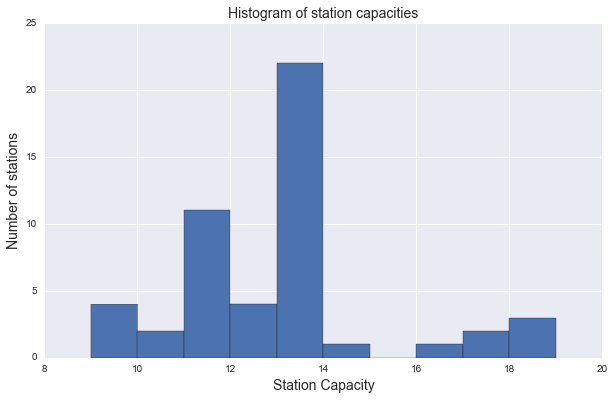

In [4]:
# Load bikes dataframe, calculate the capacity of each every 5 minutes (bikes + docks)
bikes_df = load_bikes()
bikes_df['capacity'] = bikes_df['bikes'] + bikes_df['docks']

# Now find the max capacity across all the stations at all 5 minute intervals
bikes_df = bikes_df.groupby('station_id').max().reset_index()
bikes_df = bikes_df[['station_id', 'capacity']]

# Now join with the stations dataframe using station_id
stations_cap_df = pd.merge(stations_df, bikes_df, on='station_id')

# Print the smallest and largest stations
N = 4
sorted_stations = stations_cap_df.sort_values(by='capacity', ascending=True)
print('Smallest {} stations: \n{}\n'.format(N, sorted_stations[['name', 'capacity']][:N]))
print('Largest {} stations: \n{}\n'.format(N, sorted_stations[['name', 'capacity']][-N:]))

# Show a histogram of the capacities
# fig = plt.figure()

ax1 = stations_cap_df['capacity'].plot.hist(figsize=(10,6))
ax1.set_xlabel('Station Capacity', fontsize=14)
ax1.set_ylabel('Number of stations', fontsize=14)
ax1.set_title('Histogram of station capacities', fontsize=14)

Looking at the histogram, the most popular station capacity is 13, then 11, and 9. Maybe there's an advantage to having capacity an odd number for stations ! The largest stations have a capacity of 19, and the smallest have a capacity of 9 (approximately half of the largest station).

## Station bike capacity and location

Now we have an idea of the bike station capacity, we can visualize this on a map to see if there is any relationship between their capacity and location. The plot below uses their capacity as the radius of each circle marker. For proper quantitative evaluation of the stations, we should take the square root of the radius so the areas of the circles are proportional to the capacity. But not doing this helps distinguish between the narrow range of capacities.

To find out the precise capacity of the stations, click on the circle markers.

In [5]:
# Now plot each station as a circle whose area represents the capacity
map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Hand-tuned values to make differences between circles larger
K = 0.5 
P = 2

# Add markers whose radius is proportional to station capacity. 
# Click on them to pop up their name and capacity
for station in stations_cap_df.iterrows():
    stat=station[1]
    folium.CircleMarker([stat['lat'], stat['lon']],
                        radius= K * (stat['capacity'] ** P), # Scale circles to show difference
                        popup='{} - capacity {}'.format(stat['name'], stat['capacity']),
                        fill_color='blue',
                        fill_opacity=0.8
                       ).add_to(map)
map.save('station_capacity.html')
map

The map above shows 4 of the largest stations are along the North edge of Lady Bird Lake. There is also a large station at Congress & 11th Street, at the north of the downtown area.

The downtown area is served by a larger number of smaller stations, concentrated relatively close together. East of I-35, the stations tend to be smaller and on major roads running North-to-South. The University area and South-of-the-Lake areas are more dispersed than the downtown and East areas.

## Station health

For more insight into the stations and their characteristics, we can define a metric of station 'health'. When bike stations have no bikes available, customers can't start a journey from that location. If they have no docks available, they can't end a trip at that station. In addition to the station information, we also have station bike and dock availability sampled every 5 minutes. If we count the amount of 5-minute periods a station is full or empty, this can give us a guide to its health.

In [6]:
# Load both the bikes and station dataframes
bikes_df = load_bikes()
stations_df = load_stations()

## Empty/Full station health

Now we have a list of all the bike measurements where the station was empty or full, let's aggregate by station_id and count the results. This will tell us for every station, how many 5-minute intervals it was either full or empty. This is a good indicator of which stations are often full or empty, and are unusable. Let's merge the station names so the graph makes sense.

In [7]:
# Using the bikes and stations dataframes, mask off so the only rows remaining
# are either empty or full cases from 6AM onwards
bike_empty_mask = bikes_df['bikes'] == 0
bike_full_mask = bikes_df['docks'] == 0
bike_empty_full_mask = bike_empty_mask | bike_full_mask

bikes_empty_full_df = bikes_df[bike_empty_full_mask].copy()
bikes_empty_full_df['empty'] =  bikes_empty_full_df['bikes'] == 0
bikes_empty_full_df['full'] = bikes_empty_full_df['docks'] == 0
bikes_empty_full_df.head()

,station_id,datetime,bikes,docks,empty,full
8,9,2016-04-01,13,0,False,True
21,22,2016-04-01,0,13,True,False
32,33,2016-04-01,0,13,True,False
36,37,2016-04-01,11,0,False,True
42,43,2016-04-01,9,0,False,True


## Empty/full by station in April and May 2016

Now we have a list of which stations were empty or full in each 5 minute period, we can total these up by station. If a station is either empty or full, this effectively removes it from the BCycle network temporarily. Let's use a stacked barchart to show the proportion of the time the station was full or empty. Sorting by the amount of 5-minute periods the station was full or empty also helps.

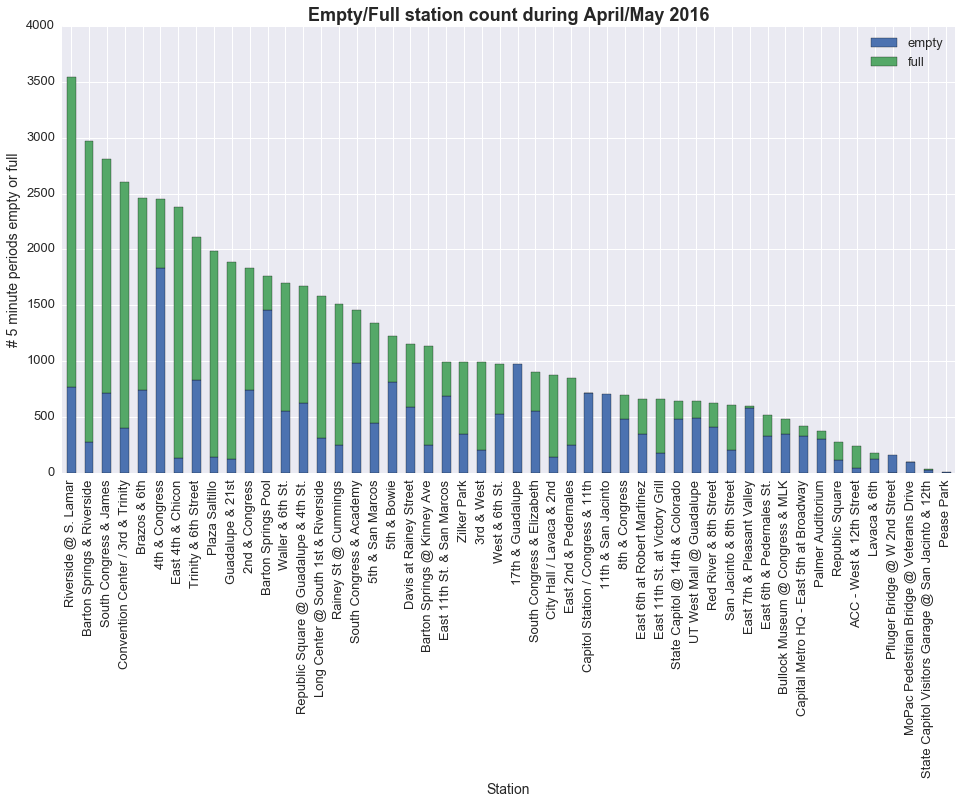

In [8]:
# Now aggregate the remaining rows by station_id, and plot the results
bike_health_df = bikes_empty_full_df.copy()
bike_health_df = bike_health_df[['station_id', 'empty', 'full']].groupby('station_id').sum().reset_index()
bike_health_df = pd.merge(bike_health_df, stations_df, on='station_id')
bike_health_df['oos'] = bike_health_df['full'] + bike_health_df['empty'] 
bike_health_df = bike_health_df.sort_values('oos', ascending=False)

ax1 = (bike_health_df[['name', 'empty', 'full']]
       .plot.bar(x='name', y=['empty', 'full'], stacked=True, figsize=(16,8)))
ax1.set_xlabel('Station', fontsize=14)
ax1.set_ylabel('# 5 minute periods empty or full', fontsize=14)
ax1.set_title('Empty/Full station count during April/May 2016',  fontdict={'size' : 18, 'weight' : 'bold'})
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax1.legend(fontsize=13)

The bar chart shows a large variation between the empty/full durations for each of the stations. The worst offender is the Riverside @ S. Lamar station, which was full or empty for a total of 12 days during the 61-day period of April and May 2016.

The proportion of empty vs full 5-minute periods also varies from station to station, shown in the relative height of the green and blue stacked bars. 

## Station empty / full percentage in April and May 2016

The barchart above shows a large variation between the 'Riverside @ S. Lamar' with ~3500 empty or full 5 minute periods, and the 'State Capitol Visitors Garage' with almost no full or empty 5 minute periods. To dig into this further, let's calculate the percentage of the time each station was neither empty nor full. This shows the percentage of the time the station was active in the BCycle system.

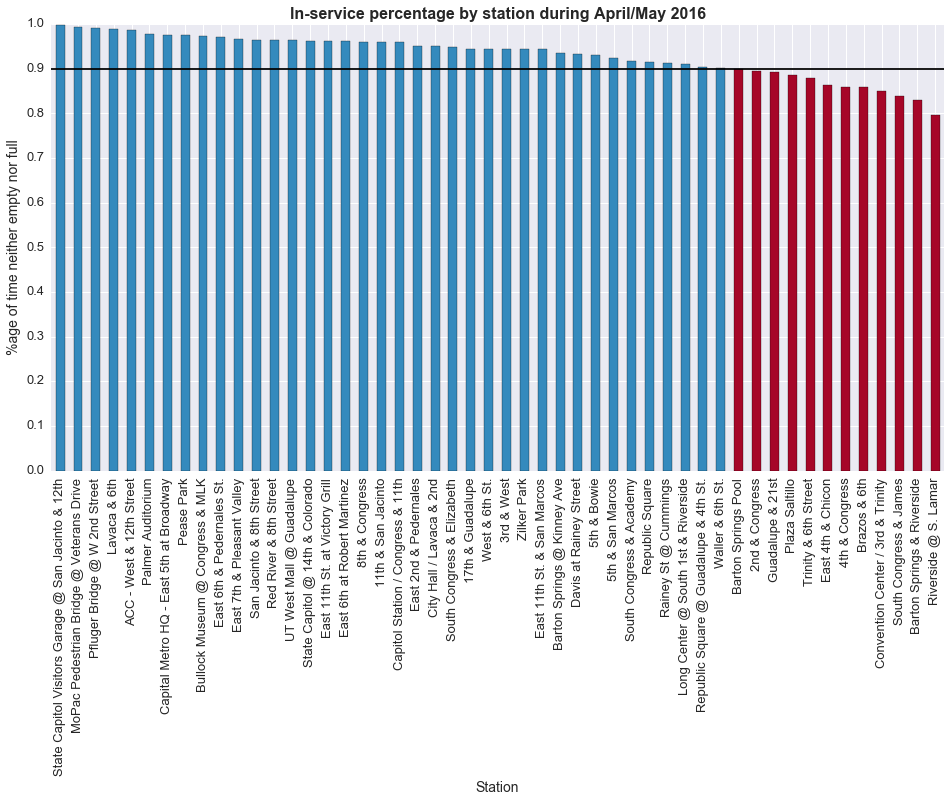

In [9]:
# For this plot, we don't want to mask out the time intervals where stations are neither full nor empty.
HEALTHY_RATIO = 0.9
station_ratio_df = bikes_df.copy()
station_ratio_df['empty'] = station_ratio_df['bikes'] == 0
station_ratio_df['full'] = station_ratio_df['docks'] == 0
station_ratio_df['neither'] = (station_ratio_df['bikes'] != 0) & (station_ratio_df['docks'] != 0)

station_ratio_df = station_ratio_df[['station_id', 'empty', 'full', 'neither']].groupby('station_id').sum().reset_index()
station_ratio_df['total'] = station_ratio_df['empty'] + station_ratio_df['full'] + station_ratio_df['neither']
station_ratio_df = pd.merge(station_ratio_df, stations_df, on='station_id')

station_ratio_df['full_ratio'] = station_ratio_df['full'] / station_ratio_df['total']
station_ratio_df['empty_ratio'] = station_ratio_df['empty'] / station_ratio_df['total']
station_ratio_df['oos_ratio'] = station_ratio_df['full_ratio'] + station_ratio_df['empty_ratio']
station_ratio_df['in_service_ratio'] = 1 - station_ratio_df['oos_ratio']
station_ratio_df['healthy'] = station_ratio_df['in_service_ratio'] >= HEALTHY_RATIO
station_ratio_df['color'] = np.where(station_ratio_df['healthy'], '#348ABD', '#A60628')

station_ratio_df = station_ratio_df.sort_values('in_service_ratio', ascending=False)
colors = ['b' if ratio >= 0.9 else 'r' for ratio in station_ratio_df['in_service_ratio']]

# station_ratio_df.head()
ax1 = (station_ratio_df.sort_values('in_service_ratio', ascending=False)
       .plot.bar(x='name', y='in_service_ratio', figsize=(16,8), legend=None, yticks=np.linspace(0.0, 1.0, 11),
                color=station_ratio_df['color']))
ax1.set_xlabel('Station', fontsize=14)
ax1.set_ylabel('%age of time neither empty nor full', fontsize=14)
ax1.set_title('In-service percentage by station during April/May 2016',  fontdict={'size' : 16, 'weight' : 'bold'})
ax1.axhline(y = HEALTHY_RATIO, color = 'black')
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

The barchart above shows that 12 of the 50 stations are either full or empty 10% of the time. 

## Table of unhealthy stations

Let's show the table of stations, with only those available 90% of the time or more included.

In [16]:
mask = station_ratio_df['healthy'] == False
unhealthy_stations_df = station_ratio_df[mask].sort_values('oos_ratio', ascending=False)
unhealthy_stations_df = pd.merge(unhealthy_stations_df, stations_cap_df[['station_id', 'capacity']], on='station_id')
unhealthy_stations_df[['name', 'oos_ratio', 'full_ratio', 'empty_ratio', 'capacity']].reset_index(drop=True).round(2)


,name,oos_ratio,full_ratio,empty_ratio,capacity
0,Riverside @ S. Lamar,0.20,0.16,0.04,11
1,Barton Springs & Riverside,0.17,0.15,0.02,11
2,South Congress & James,0.16,0.12,0.04,9
3,Convention Center / 3rd & Trinity,0.15,0.13,0.02,11
4,Brazos & 6th,0.14,0.10,0.04,11
5,4th & Congress,0.14,0.04,0.10,13
6,East 4th & Chicon,0.14,0.13,0.01,9
7,Trinity & 6th Street,0.12,0.07,0.05,11
8,Plaza Saltillo,0.11,0.11,0.01,12
9,Guadalupe & 21st,0.11,0.10,0.01,13


## Stations empty / full based on their location

After checking the proportion of time each station has docks and bikes available above, we can visualize these on a map, to see if there is any correlation in their location.

In the map below, the circle markers use both colour and size as below:

* The colour of the circle shows whether the station is available less than 90% of the time. Red stations are in the unhealthy list above, and are empty or full 10% or more of the time. Blue stations are the healthy stations available 90% or more of the time.
* The size of the circle shows how frequently the station is empty or full.

To see details about the stations, you can click on the circle markers.

In [11]:
# Merge in the station capacity also for the popup markers
station_ratio_cap_df = pd.merge(station_ratio_df, stations_cap_df[['station_id', 'capacity']], on='station_id')

map = folium.Map(location=(center_lat, center_lon), 
                 zoom_start=14, 
                 tiles='Stamen Toner',
                 control_scale=True)

# Hand-tuned parameter to increase circle size
K = 1000
C = 5
for station in station_ratio_cap_df.iterrows():
    stat = station[1]
    
    if stat['healthy']:
        colour = 'blue'
    else:
        colour='red'
    
    folium.CircleMarker([stat['lat'], stat['lon']], radius=(stat['oos_ratio'] * K) + C,
                        popup='{}, empty {:.1f}%, full {:.1f}%, capacity {}'.format(
                          stat['name'], stat['empty_ratio']*100, stat['full_ratio']*100, stat['capacity']),
                        fill_color=colour, fill_opacity=0.8
                       ).add_to(map)

map.save('unhealthy_stations.html')
map

The map shows that stations most frequently unavailable can be grouped into 3 clusters:

1. The downtown area around East 6th Street between Congress and I-35 and Red River street. This area has a large concentration of businesses, restaurants and bars. Their capacity is around 11 - 13, and they tend to be full most of the time.
2. South of the river along the Town Lake hiking and cycling trail along with South Congress. The Town Lake trail is a popular cycling route, and there are many restaurants and bars on South Congress. Both Riverside @ S.Lamar and Barton Springs at Riverside have capacities of 11, and are full 15% of the time. 
3. Stations along East 5th Street, near the downtown area. This area has a lot of bars and restaurants, people may be using BCycles to get around to other bars. Their capacity is 12 and 9, and they're full 10% or more of the time. These stations would also benefit from extra capacity.
4. The South Congress trio of stations is interesting. They are all only a block or so away from each other, but the South Congress and James station has a capacity of 9, is full 12% of the time, and empty 4%. The other two stations on South Congress have a capacity of 13 each, and are full for much less of the time.

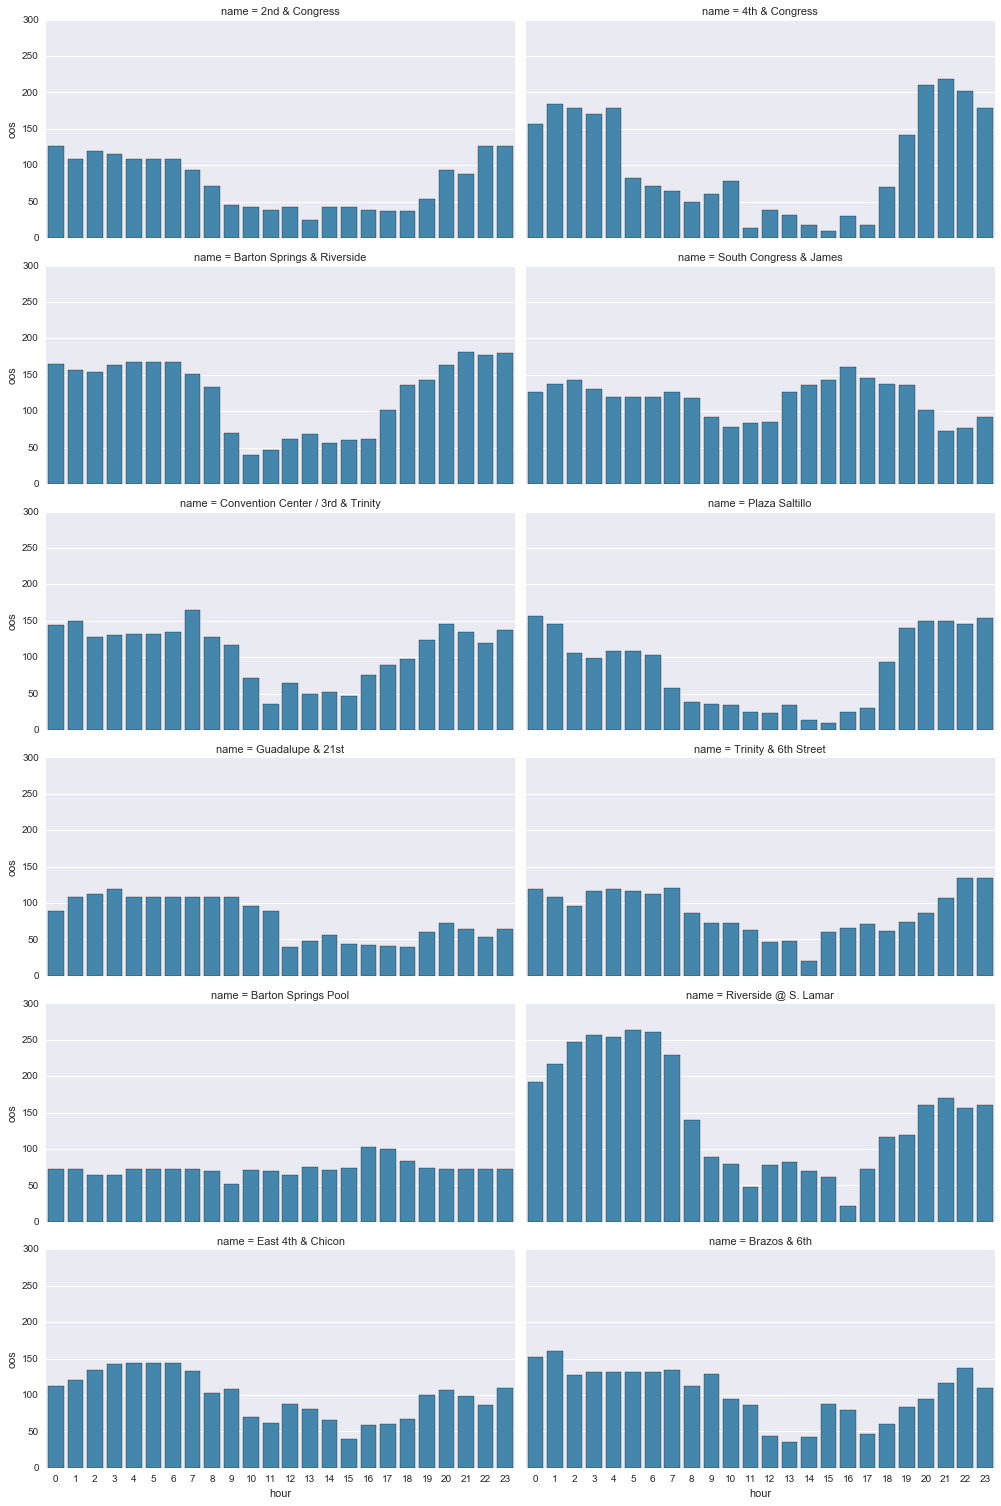

In [12]:
# Plot the empty/full time periods grouped by hour for the top 10 
oos_stations_df = bikes_df.copy()
oos_stations_df['empty'] = oos_stations_df['bikes'] == 0
oos_stations_df['full'] = oos_stations_df['docks'] == 0
oos_stations_df['neither'] = (oos_stations_df['bikes'] != 0) & (oos_stations_df['docks'] != 0)
oos_stations_df['hour'] = oos_stations_df['datetime'].dt.hour

oos_stations_df = (oos_stations_df[['station_id', 'hour', 'empty', 'full', 'neither']]
                   .groupby(['station_id', 'hour']).sum().reset_index())
oos_stations_df = oos_stations_df[oos_stations_df['station_id'].isin(unhealthy_stations_df['station_id'])]
oos_stations_df['oos'] = oos_stations_df['empty'] + oos_stations_df['full'] 
oos_stations_df = pd.merge(stations_df, oos_stations_df, on='station_id')

oos_stations_df

g = sns.factorplot(data=oos_stations_df, x="hour", y="oos", col='name',
                   kind='bar', col_wrap=2, size=3.5, aspect=2.0, color='#348ABD')

## Correlation between station empty/full and station capacity

Perhaps the reason stations are empty or full a lot is because they have a smaller capacity. Smaller stations would quickly run out of bikes, or become more full. Let's do a hypothesis test, assuming p < 0.05 for statistical significance.

* Null hypothesis: The capacity of the station is not correlated with the full count.
* Alternative hypothesis: The capacity of the station is correlated with the full count.

The plot below shows a negative correlation between the capacity of a station, and how frequently it becomes full. The probability of a result this extreme is 0.0086 given the null hypothesis, so we reject the null hypothesis. Stations with larger capacities become full less frequently.

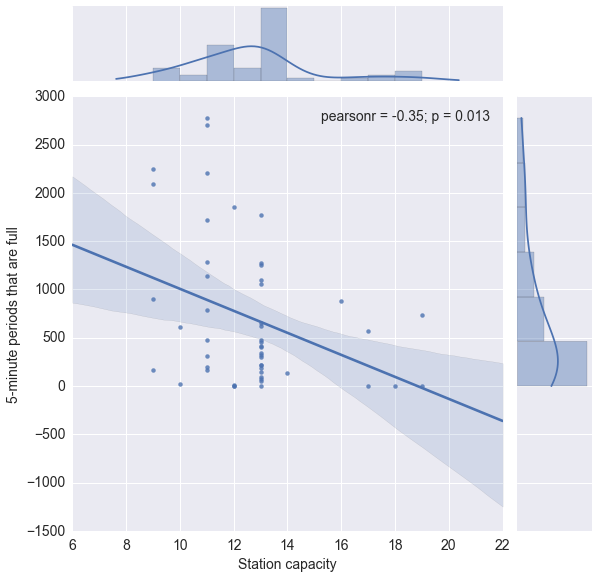

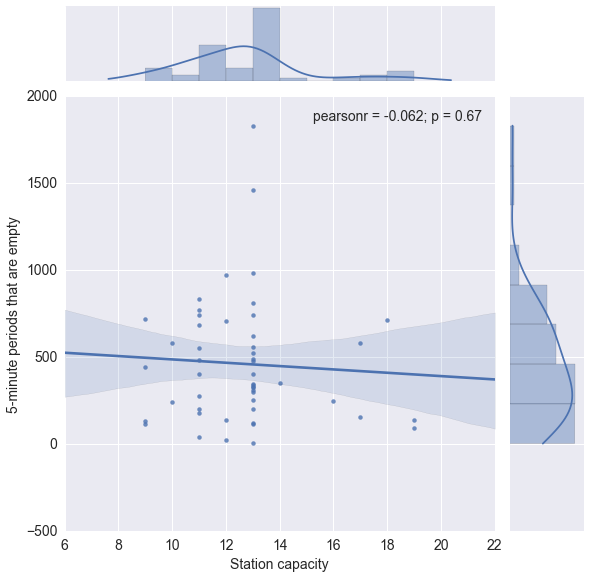

In [13]:
bikes_capacity_df = bikes_df.copy()
bikes_capacity_df['capacity'] = bikes_capacity_df['bikes'] + bikes_capacity_df['docks']

# Now find the max capacity across all the stations at all 5 minute intervals
bikes_capacity_df = bikes_capacity_df.groupby('station_id').max().reset_index()
bike_merged_health_df = pd.merge(bike_health_df, 
                                 bikes_capacity_df[['station_id', 'capacity']], 
                                 on='station_id', 
                                 how='inner')

# sns.lmplot(data=bike_merged_health_df, x='capacity', y='count')

plt.rc("legend", fontsize=14) 
sns.jointplot("capacity", "full", data=bike_merged_health_df, kind="reg", size=8)
plt.xlabel('Station capacity', fontsize=14)
plt.ylabel('5-minute periods that are full', fontsize=14)
plt.tick_params(axis="both", labelsize=14)


sns.jointplot("capacity", "empty", data=bike_merged_health_df, kind="reg", size=8)
plt.xlabel('Station capacity', fontsize=14)
plt.ylabel('5-minute periods that are empty', fontsize=14)
plt.tick_params(axis="both", labelsize=14)

## Station empty / full by Time

To break the station health down further, we can check in which 5 minute periods the station was either full or empty. By grouping the results over various time scales, we can look for periodicity in the data.

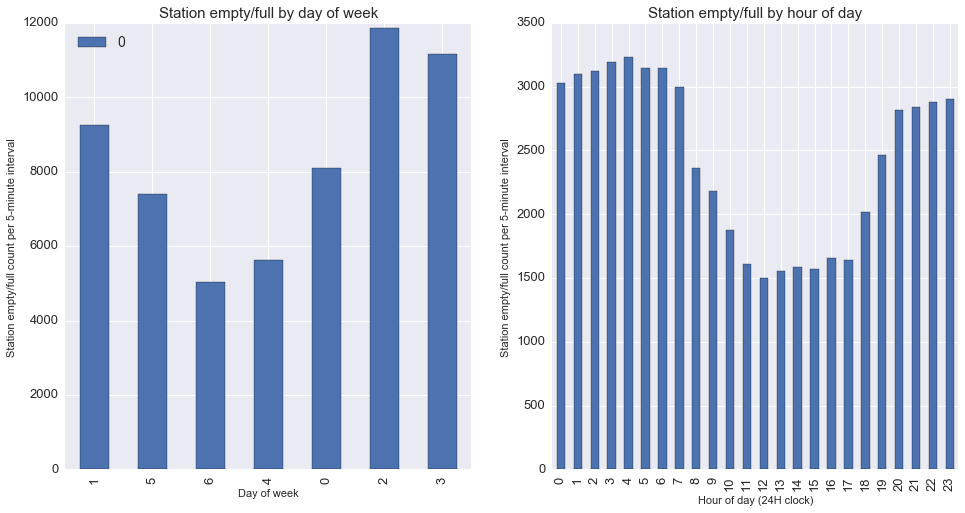

In [14]:
bikes_df = load_bikes()
empty_mask = bikes_df['bikes'] == 0
full_mask = bikes_df['docks'] == 0
empty_full_mask = empty_mask | full_mask
bikes_empty_full_df = bikes_df[empty_full_mask].copy()
bikes_empty_full_df['day_of_week'] = bikes_empty_full_df['datetime'].dt.weekday_name
bikes_empty_full_df['hour'] = bikes_empty_full_df['datetime'].dt.hour

fig, axes = plt.subplots(1,2, figsize=(16,8))
bikes_empty_full_df.groupby(['day_of_week']).size().reset_index('day_of_week').iloc[[1,5,6,4,0,2,3],:].plot.bar(ax=axes[0])
axes[0].set_xlabel('Day of week')
axes[0].set_ylabel('Station empty/full count per 5-minute interval ')
axes[0].set_title('Station empty/full by day of week', fontsize=15)
axes[0].tick_params(axis='x', labelsize=13)
axes[0].tick_params(axis='y', labelsize=13)

bikes_empty_full_df.groupby(['hour']).size().plot.bar(ax=axes[1])
axes[1].set_xlabel('Hour of day (24H clock)')
axes[1].set_ylabel('Station empty/full count per 5-minute interval ')
axes[1].set_title('Station empty/full by hour of day', fontsize=15)
axes[1].tick_params(axis='x', labelsize=13)
axes[1].tick_params(axis='y', labelsize=13)

These plots show how many 5-minute periods there were across all stations where a station was either empty or full. The left plot aggregates by the day-of-the-week, and the right plot uses the hour of the day.

The left plot shows there are more 5-minute periods where the stations are empty or full on the weekend. This implies that the bcycle system is being more "stressed" on the weekends, where recreational biking is more prevalent.

The right plot shows the amount of stations which are empty/full for each hour of the day. There's a pattern here, which can be grouped as follows:

* Between midnight (00:00) and 7AM (07:00) stations in the system are more empty or full. Because there are few cycle trips taking place in this part of the day, stations which are either empty or full will remain that way. I'm also assuming the BCycle rebalancing doesn't take place, so stations are effectively left as they are.

* Between 8AM (08:00) and midday (12:00), the amount of stations which are empty or full steadily decreases. This could be because commuter trips effectively rebalance the network, and/or BCycle's trucks are manually rebalancing the network.

* Between midday (12:00) and 5PM (17:00), the amount of stations empty or full remains constant. This is likely due to the BCycle trucks rebalancing stations, or bike trips being "out-and-back" as opposed to point-to-point.

* After 5PM (17:00) the amount of empty/full stations gradually increases. During this time, commuters are finishing work and returning home, and the BCycle rebalancing is winding down at the end of the business day.